## Digit Recognizer
https://www.kaggle.com/c/digit-recognizer

In [1]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt

## Загружаем исходные данные

In [2]:
train = np.loadtxt('C:/Users/Аня/Documents/Python Scripts/нетология/002/train.csv', delimiter=',', skiprows=1)
test = np.loadtxt('C:/Users/Аня/Documents/Python Scripts/нетология/002/test.csv', delimiter=',', skiprows=1)

In [3]:
np.shape(train)

(42000, 785)

In [4]:
# сохраняем разметку в отдельную переменную
train_label = train[:, 0]
# приводим размерность к удобному для обаботки виду
train_img = np.resize(train[:, 1:], (train.shape[0], 28, 28))
test_img = np.resize(test, (test.shape[0], 28, 28))

In [5]:
train_img.shape

(42000, 28, 28)

## Визуализируем исходные данные

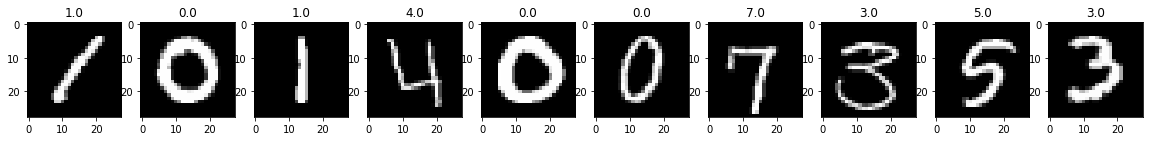

In [6]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_img[0:10], 1):
    subplot = fig.add_subplot(1, 10, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);

## Разрезаем изображения на четыре части

In [7]:
def splits(images):
    imades_splits = []
    for ind, img in enumerate(images):
        k = [img[ :14, 14:], img[ 14:, :14], img[:14, :14], img[14:, 14:]]
        imades_splits += k
    return imades_splits 

In [8]:
train_img_splits = splits(train_img)
test_img_splits = splits(test_img)

In [9]:
len(train_img_splits)

168000

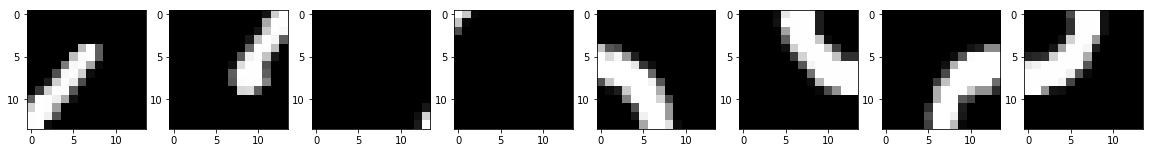

In [10]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_img_splits[0:8], 1):
    subplot = fig.add_subplot(1, 8, i)
    plt.imshow(img, cmap='gray');

## Вычисляем X и Y составляющие градиента с помощью оператора Собеля

In [11]:
test_sobel_x = np.zeros_like(test_img_splits)
test_sobel_y = np.zeros_like(test_img_splits)
for i in range(len(test_img_splits)):
    test_sobel_x[i] = cv2.Sobel(test_img_splits[i], cv2.CV_64F, dx=1, dy=0, ksize=3)
    test_sobel_y[i] = cv2.Sobel(test_img_splits[i], cv2.CV_64F, dx=0, dy=1, ksize=3)

In [12]:
train_sobel_x = np.zeros_like(train_img_splits)
train_sobel_y = np.zeros_like(train_img_splits)
for i in range(len(train_img_splits)):
    train_sobel_x[i] = cv2.Sobel(train_img_splits[i], cv2.CV_64F, dx=1, dy=0, ksize=3)
    train_sobel_y[i] = cv2.Sobel(train_img_splits[i], cv2.CV_64F, dx=0, dy=1, ksize=3)

## Вычисляем угол и длину вектора градиента

In [13]:
train_g, train_theta = cv2.cartToPolar(train_sobel_x, train_sobel_y)
test_g, test_theta = cv2.cartToPolar(test_sobel_x, test_sobel_y)

## Вычисляем гистограммы градиентов

In [14]:
# Гистограммы вычисляются с учетом длины вектора градиента
train_hist = np.zeros((len(train_img_splits), 16))
for i in range(len(train_img_splits)):
    hist, borders = np.histogram(train_theta[i],
                                 bins=16,
                                 range=(0., 2. * np.pi),
                                 weights=train_g[i])
    train_hist[i] = hist

In [15]:
test_hist = np.zeros((len(test_img_splits), 16))
for i in range(len(test_img_splits)):
    hist, borders = np.histogram(test_theta[i],
                                 bins=16,
                                 range=(0., 2. * np.pi),
                                 weights=test_g[i])
    test_hist[i] = hist

## Сконкатенируем полученные гистограммы для каждого изображения в один вектор

In [16]:
train_hist_new = []
for i in range(1,len(train_hist)//4+1):
    train_hist_new.append(np.concatenate(train_hist[4*(i-1):4*i]))

In [17]:
test_hist_new = []
for i in range(1,len(test_hist)//4+1):
    test_hist_new.append(np.concatenate(test_hist[4*(i-1):4*i]))

In [18]:
np.shape(test_hist_new)

(28000, 64)

## Нормируем вектор гистограммы

In [19]:
train_hist_new = train_hist_new / np.linalg.norm(train_hist_new, axis=1)[:, None]
test_hist_new = test_hist_new / np.linalg.norm(test_hist_new, axis=1)[:, None]

##  Разбиваем выборку на обучение и валидацию

In [20]:
from sklearn.model_selection import train_test_split
y_train, y_val, x_train, x_val = train_test_split(train_label, train_hist_new, test_size=0.2)

## Вычисляем центроиды каждого из 10 классов

In [21]:
centroids = np.zeros((10, train_hist_new.shape[1]), dtype=np.float32)
for i in range(10):
    centroids[i] = np.mean(x_train[y_train == i], axis=0)

##  Находим ближайший центройд для валидации

In [22]:
pred_val = np.zeros_like(y_val)
for i in range(len(y_val)):
    distances = np.linalg.norm(centroids - x_val[i], axis=1)
    pred_val[i] = np.argmin(distances)

##  Оцениваем качество решение на валидационной выборке

In [23]:
from sklearn.metrics import accuracy_score
print('Accuracy: %s' % accuracy_score(y_val, pred_val))

Accuracy: 0.844880952381


In [24]:
from sklearn.metrics import classification_report
print(classification_report(y_val, pred_val))

             precision    recall  f1-score   support

        0.0       0.91      0.93      0.92       820
        1.0       0.93      0.91      0.92       883
        2.0       0.86      0.87      0.86       842
        3.0       0.79      0.85      0.82       889
        4.0       0.93      0.84      0.88       843
        5.0       0.88      0.85      0.86       765
        6.0       0.89      0.91      0.90       799
        7.0       0.90      0.75      0.82       931
        8.0       0.68      0.77      0.72       802
        9.0       0.72      0.78      0.75       826

avg / total       0.85      0.84      0.85      8400



In [25]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_val, pred_val))

[[766   3   3  12   8   2   5   0  18   3]
 [  0 804  13   0   2   0   2   0  45  17]
 [ 12   5 729  43   5   1   4   6  30   7]
 [  5   0  26 760   1  38   3  13  13  30]
 [  0  10   8   5 708   0  29   2  29  52]
 [  4   0   0  65   1 647  12   3  20  13]
 [ 12  10   0   0  13   4 730   0  28   2]
 [  9  23  43  22   2   0   4 696  33  99]
 [ 21  12  21  24  10  34  29   9 614  28]
 [ 16   2   1  25  11   6   4  42  76 643]]


## Предсказания на тестовыйх данных

In [26]:
pred_test = np.zeros(len(test_img), np.uint8)
for i in range(len(test_img)):
    distances = np.linalg.norm(centroids - test_hist_new[i], axis=1)
    pred_test[i] = np.argmin(distances)

In [27]:
with open('submit.txt', 'w') as dst:
    dst.write('ImageId,Label\n')
    for i, p in enumerate(pred_test, 1):
        dst.write('%s,%s\n' % (i, p))

##  Визуализируем предсказания

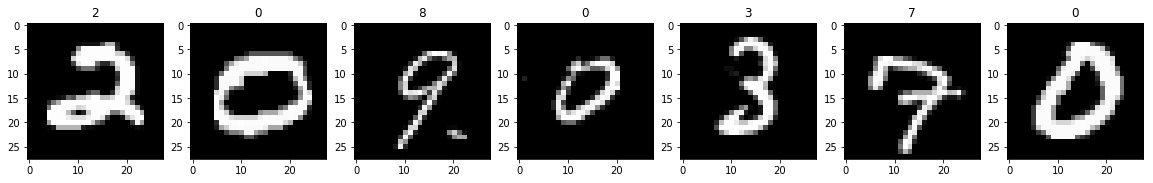

In [28]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(test_img[0:7], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % pred_test[i - 1])

предсказание на kaggle - 0.84314

## Снизим размерность с помощью PCA

In [29]:
import numpy as np
from sklearn.decomposition import PCA
pca = PCA()
x = pca.fit(train[:, 1:])

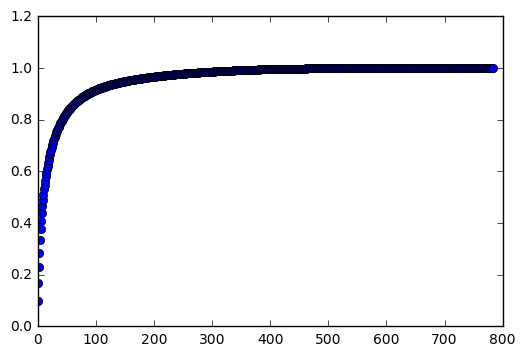

In [30]:
S = pca.explained_variance_ratio_
S_cumsum = np.cumsum(S) / np.sum(S)
plt.plot(S_cumsum, 'o')
plt.show()

In [31]:
S_thr = 0.9  # задаем порог для накопленной суммы собственных значений

# определяем необходимое число компонент для заданного порога
n_comp = np.argmax(np.where(S_cumsum > S_thr, 1, 0))
print('n_comp=%d S=%.3f' % (n_comp, S_cumsum[n_comp]))

n_comp=86 S=0.901


In [41]:
from sklearn.decomposition import PCA
pca = PCA(n_components=86)
pca.fit(train[:, 1:])

PCA(copy=True, iterated_power='auto', n_components=86, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [42]:
X_train_pca = np.dot(train[:, 1:], pca.components_.T)
X_test_pca = np.dot(test, pca.components_.T)

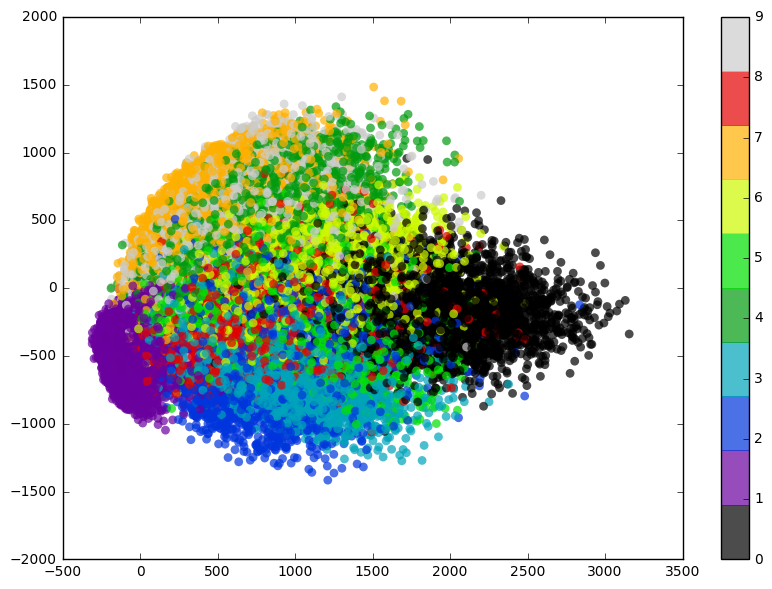

In [35]:
plt.figure(figsize=(10,7))
plt.scatter(X_train_pca[:, 0],X_train_pca[:, 1], c=train_label, 
            edgecolor='none', alpha=0.7, s=40,
            cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.colorbar()

In [59]:
from sklearn.neighbors import KNeighborsClassifier

In [60]:
knn = KNeighborsClassifier().fit(X_train_pca, train_label )

In [61]:
pred = knn.predict(X_test_pca)

In [64]:
with open('submit.txt', 'w') as dst:
    dst.write('ImageId,Label\n')
    for i, p in enumerate(pred, 1):
        dst.write('%s,%s\n' % (i, int(p)))

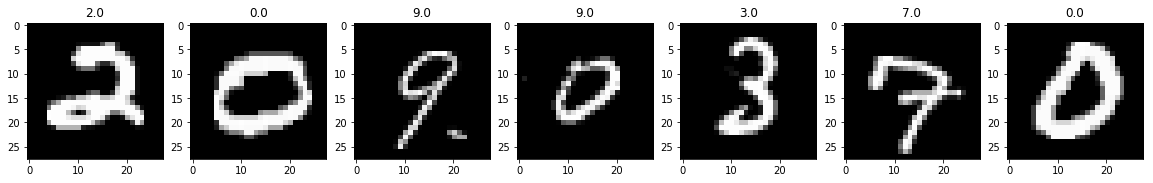

In [62]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(test_img[0:7], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % pred[i - 1 ])

предсказание на kaggle - 0.97200

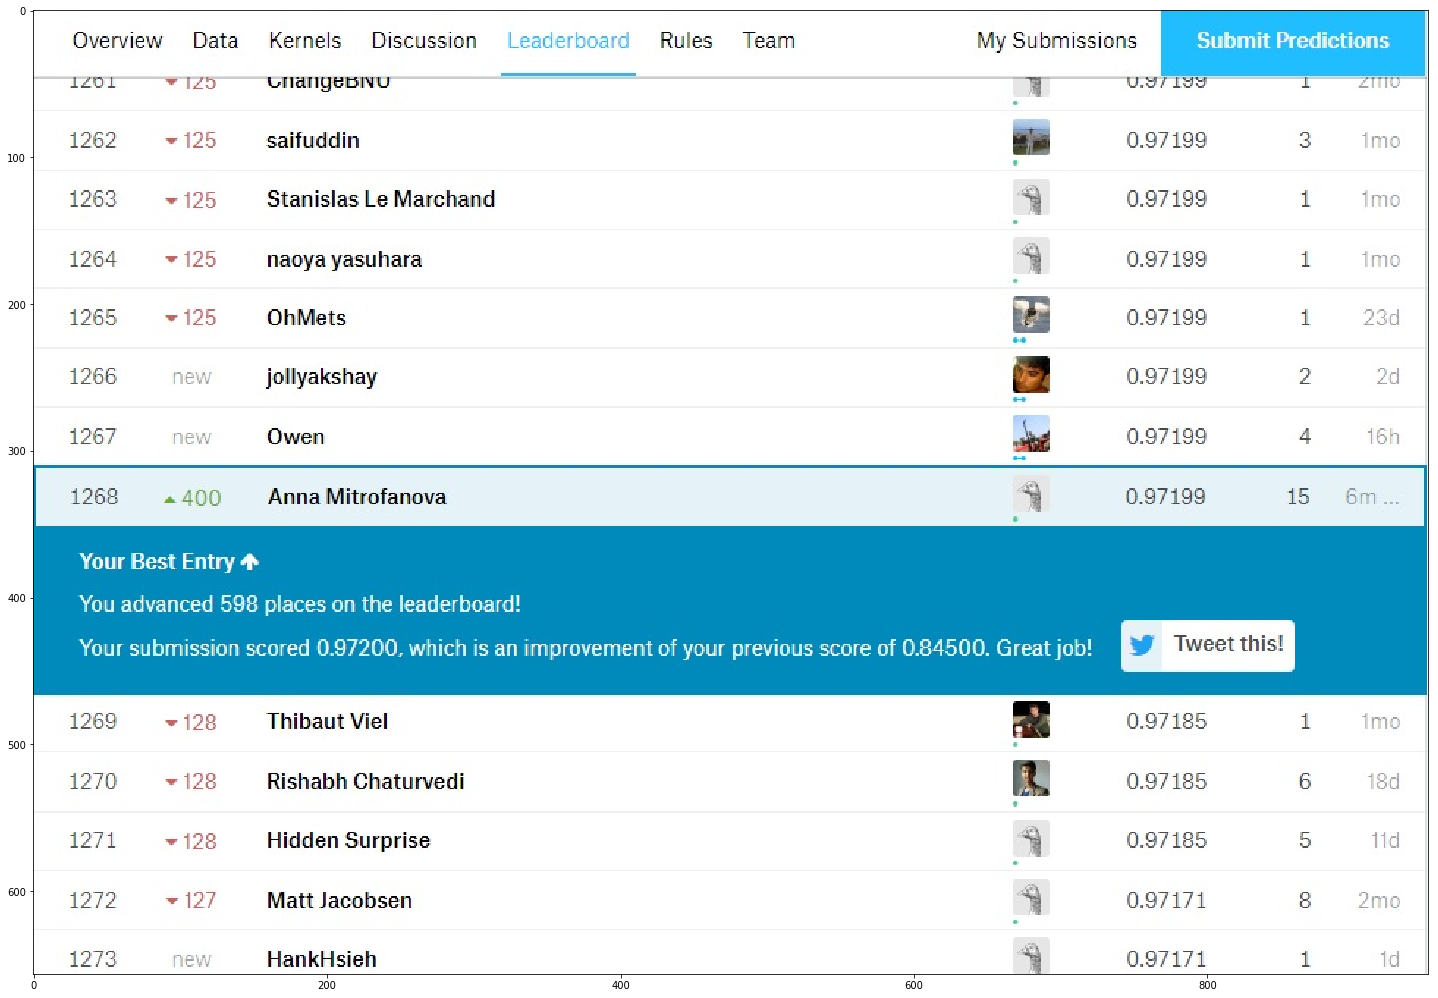

In [81]:
img = cv2.imread('./submit.png')
plt.figure(figsize = (25,25))
plt.imshow(img[...,::-1])